<a href="https://colab.research.google.com/github/AbdelrahmanKK/NoduleMNIST3D-classification/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import dependencies

In [ ]:
!pip install medmnist
!pip install monai
!pip install ray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116933 sha256=a620dc19ff7b9ef03a0d6ceed0138bb32d3dc63176d7ebec39e6f75f8bc87fe5
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 9.3 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from matplotlib import pyplot as plt
import medmnist
from medmnist import NoduleMNIST3D


from ray import tune
from ray.air import  session
from ray.tune.schedulers import ASHAScheduler


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import WeightedRandomSampler

from torchvision.transforms import v2
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
from numpy.random.mtrand import random
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
    NormalizeIntensity,
    Resize,
)



from monai.networks.nets import DenseNet121


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device -- > " + str(device))

Device -- > cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data Setup and Configuration



- **NUM_EPOCHS**: The number of training epochs

- **BATCH_SIZE**

- **learn_rate**

- **info**: This dictionary contains information about the  dataset, such as the task, number of channels, and class labels.

- **n_channels**: Indicates the number of image channels (e.g., 1 for grayscale, 3 for RGB).

- **n_classes**: Specifies the number of classes or categories in the dataset.




In [ ]:
# hyparameters
BATCH_SIZE = 80
EPOCH_NUM = 20
learn_rate = 0.00001

# dataset
data_name = 'nodulemnist3d'
info = medmnist.INFO[data_name]
n_channels = info['n_channels']
n_classes = len(info['label'])
print(info)

{'python_class': 'NoduleMNIST3D', 'description': 'The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.', 'url': 'https://zenodo.org/record/6496656/files/nodulemnist3d.npz?download=1', 'MD5': '8755a7e9e05a4d9ce80a24c3e7a256f3', 'task': 'binary-class', 'label': {'0': 'benign', '1': 'malignant'}, 'n_channels': 1, 'n_samples': {'train': 1158, 'val': 165, 'test': 310}, 'license': 'CC BY 4.0'}


# Data augmentation


In [ ]:
# transforms =  Compose([
                    # ToTensor(),
#                   ScaleIntensity(minv=1,maxv=2),
#                   RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
#                   RandFlip(spatial_axis=0, prob=0.5),
#                   NormalizeIntensity(),
#                   ])

transforms = Compose([
    ToTensor(),
    NormalizeIntensity(),

])


# Download Dataset

### Split from "MedMNIST v2" paper is
### Train : Validation : Test = 7 : 1 : 2



In [ ]:

train_dataset = NoduleMNIST3D(split='train',transform = transforms, download=True)
validation_dataset = NoduleMNIST3D(split='val', transform = transforms, download=True)



# Some details
print(train_dataset)
print("===================")
print(validation_dataset)



Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Dataset NoduleMNIST3D (nodulemnist3d)
    Number of datapoints: 1158
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'benign', '1': 'malignant'}
    Number of samples: {'train': 1158, 'val': 165, 'test': 310}
    Description: The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing 

# Create data loaders

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  # shuffling is enabled in the training
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)



# Check the count of each class





benign = 863
maliginant = 295


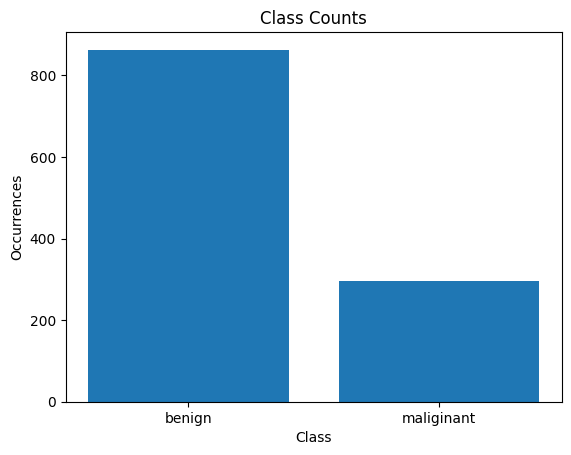

In [ ]:
class_names = ['benign', 'maliginant']
class_counts = [0, 0]

for batch ,labels in train_loader:
    for label in labels:
        class_counts[label] += 1

print(class_names[0] +' = '+ str(class_counts[0]))
print(class_names[1] +' = '+ str(class_counts[1]))
x_pos = np.arange(len(class_names))
plt.bar(x_pos, class_counts)
plt.xticks(x_pos, class_names)
plt.xlabel('Class')
plt.ylabel('Occurrences')
plt.title('Class Counts')
plt.show()

# Addressing class imbalance

If we want to reduce the class imbalance, we could duplicate the malignant data. I tried it but there was no major improvment.

In [ ]:
# print(len(train_dataset))
# duplicated_data = []
# for data, target in train_dataset:
#     if target[0] == 1:
#         duplicated_data.append((data, target))

# # Concatenate the original dataset with the duplicated elements
# train_dataset = torch.utils.data.ConcatDataset([train_dataset, duplicated_data])

# print(len(train_dataset))


# Visulaization

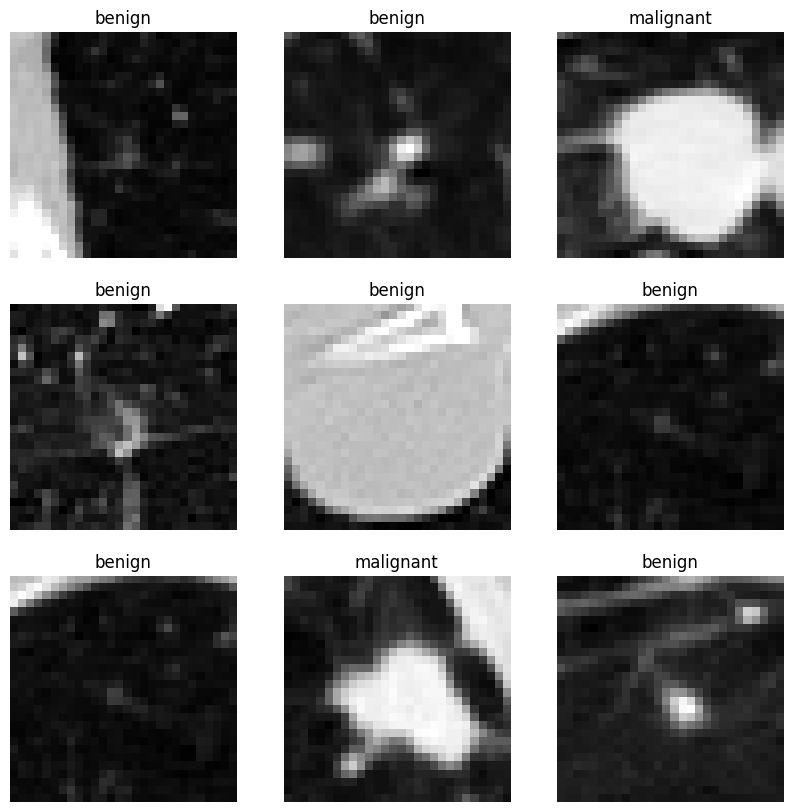

In [ ]:

labels_map = {
    0: "benign",
    1: "malignant",
}


random_batch = next(iter(train_loader))
images = random_batch[0]
labels = random_batch[1]
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    index = np.random.randint(0, len(images))
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[index][0].permute(1, 2, 0)[:,:,12],cmap = "gray")

    plt.axis('off')
    plt.title(labels_map[torch.IntTensor.item(labels[index][0])])


# 5-layer 3D CNN implementation
#### **Model Architecture**



- in_channels:  number of input channels, ,will be 1 for our example
- num_classes:  number of classes

#### The layers and their operations are as follows:
1. layer1: Convolutional layer with 16 filters, batch normalization, and ReLU activation.
2. layer2: Convolutional layer with 16 filters, batch normalization, ReLU activation, and max-pooling.
3. layer3: Convolutional layer with 64 filters, batch normalization, and ReLU activation.
4. layer4: Convolutional layer with 64 filters, batch normalization, and ReLU activation.
5. layer5: Convolutional layer with 64 filters, batch normalization, ReLU activation, and max-pooling.
6. fullyconnected: Fully connected layers for classification.

In [ ]:
class CNN_3D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_3D, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, kernel_size=3),
            nn.BatchNorm3d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv3d(16, 16, kernel_size=3),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv3d(16, 64, kernel_size=3),
            nn.BatchNorm3d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=3),
            nn.BatchNorm3d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))

        self.fullyconnected = nn.Sequential(
            nn.Linear(64*4*4*4 , 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.layer1(x.float())
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fullyconnected(x)
        x = torch.sigmoid(x)
        return x


model = CNN_3D(in_channels=n_channels, num_classes=n_classes).to(device)


**Note**:  I tried denseNet121 and monai classifier but the results was not  better

In [ ]:
# model = Classifier(in_shape=[1, 28, 28, 28], classes=2,
#                    channels=(8, 16, 32, 64), strides=(2, 2, 2)).to(device)
# model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=1).to(device)

# Loss function and Optimizer

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = learn_rate)

# Model Summary

In [ ]:
random_sample, randmom_label = train_dataset[0]
summary(model, random_sample.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 26, 26, 26]             448
       BatchNorm3d-2       [-1, 16, 26, 26, 26]              32
              ReLU-3       [-1, 16, 26, 26, 26]               0
            Conv3d-4       [-1, 16, 24, 24, 24]           6,928
       BatchNorm3d-5       [-1, 16, 24, 24, 24]              32
              ReLU-6       [-1, 16, 24, 24, 24]               0
         MaxPool3d-7       [-1, 16, 12, 12, 12]               0
            Conv3d-8       [-1, 64, 10, 10, 10]          27,712
       BatchNorm3d-9       [-1, 64, 10, 10, 10]             128
             ReLU-10       [-1, 64, 10, 10, 10]               0
           Conv3d-11          [-1, 64, 8, 8, 8]         110,656
      BatchNorm3d-12          [-1, 64, 8, 8, 8]             128
             ReLU-13          [-1, 64, 8, 8, 8]               0
           Conv3d-14          [-1, 64, 

In [ ]:
def progress_bar(progress, total):
    """
    A method to visualize the training progress by a progress bar

    Parameters
    ----------
    progress: float
        the current batch
    total: float
        the total number of batches
    """
    percent = 50 * (progress / float(total))
    bar = "#" * int(percent) + "_" * (50 - int(percent))
    print(f"\r|{bar}| {2 * percent: .2f}%", end=" ")



def train(train_loader, model, optimizer, criterion, EPOCH_NUM, validation_loader):
    '''
    Returns 2 lists,

    * training loss values :train_loss_values,
    *  validation loss values:  val_loss_values
    '''
    train_loss_values = []
    val_loss_values = []
    # Training loop

    for epoch in range(EPOCH_NUM):
        model.train()
        batch_loss = 0.0
        progress_bar(0, len(train_loader))

        for batch_num, batch in enumerate(train_loader):
            progress_bar(batch_num + 1, len(train_loader))
            images, labels = batch
            images, labels = images.to(device), labels.to(device)  # Move the data to the same device
            images=images.float()

            # Forward
            outputs = model(images)
            loss = criterion(outputs.float(), labels.float())

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss += loss.item()

        epoch_loss = batch_loss / len(train_loader)
        train_loss_values.append(epoch_loss)

        # Validation loop
        model.eval()
        val_batch_loss = 0.0
        with torch.no_grad():
            for val_images, val_labels in validation_loader:

                val_images, val_labels = val_images.to(device,dtype=torch.float), val_labels.to(device, dtype=torch.float)  # Move validation data to the same device
                val_outputs = model(val_images)

                val_loss = criterion(val_outputs.float(), val_labels.float())
                val_batch_loss += val_loss.item()

            val_epoch_loss = val_batch_loss / len(validation_loader)
            val_loss_values.append(val_epoch_loss)

        if epoch % 1 == 0:
            print(f"Epoch [{epoch+1}/{EPOCH_NUM}], Training Loss: {epoch_loss:.5}, Validation Loss: {val_epoch_loss:.5}")

    return train_loss_values, val_loss_values


def test(data_loader, model, criterion):
    test_loss_values = []
    predictions = []
    actuals = []

    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            images=images.float()

            outputs = model(images)
            loss = criterion(outputs.float(), labels.float())
            test_loss_values.append(loss.item())

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    AUC = roc_auc_score(actuals, predictions)
    ACC = accuracy_score(np.round(predictions), actuals)

    return actuals ,predictions, AUC, ACC

# Training and Evaluation With learning Curves


|##################################################|  100.00% Epoch [1/20], Training Loss: 0.63185, Validation Loss: 0.68707
|##################################################|  100.00% Epoch [2/20], Training Loss: 0.55672, Validation Loss: 0.62426
|##################################################|  100.00% Epoch [3/20], Training Loss: 0.51279, Validation Loss: 0.54201
|##################################################|  100.00% Epoch [4/20], Training Loss: 0.4756, Validation Loss: 0.48438
|##################################################|  100.00% Epoch [5/20], Training Loss: 0.4459, Validation Loss: 0.45269
|##################################################|  100.00% Epoch [6/20], Training Loss: 0.42042, Validation Loss: 0.42235
|##################################################|  100.00% Epoch [7/20], Training Loss: 0.4046, Validation Loss: 0.4048
|##################################################|  100.00% Epoch [8/20], Training Loss: 0.38955, Validation Loss: 0.39145
|###

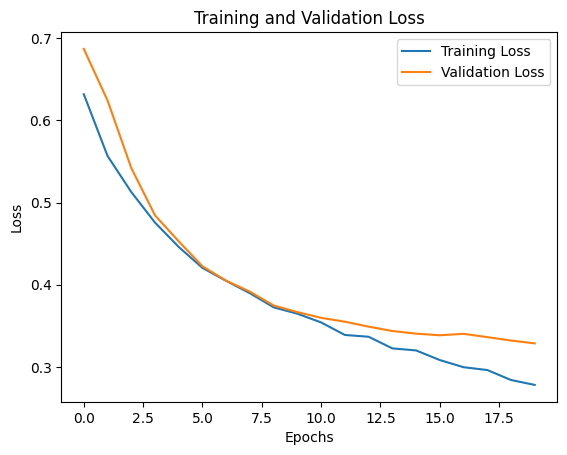

In [ ]:
train_loss, val_loss = train(train_loader, model, optimizer, criterion, EPOCH_NUM, validation_loader)


# learning curves
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
actuals_train, predictions_train, AUC_train, ACC_train = test(train_loader, model,criterion)
actuals_val, predictions_val, AUC_val, ACC_val = test(validation_loader, model,criterion)


print(f' Training --> AUC: {AUC_train:.3f}, ACC: {ACC_train:.3f}\n')
print(f' Validation --> AUC: {AUC_val:.3f}, ACC: {ACC_val:.3f}\n')


 Training --> AUC: 0.946, ACC: 0.890

 Validation --> AUC: 0.879, ACC: 0.848



# Receiver Operating Characteristic (ROC) Curve

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. [(Reference)](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=An%20ROC%20curve%20(receiver%20operating,True%20Positive%20Rate). This curve plots two parameters:

*   True Positive Rate
*   False Positive Rate




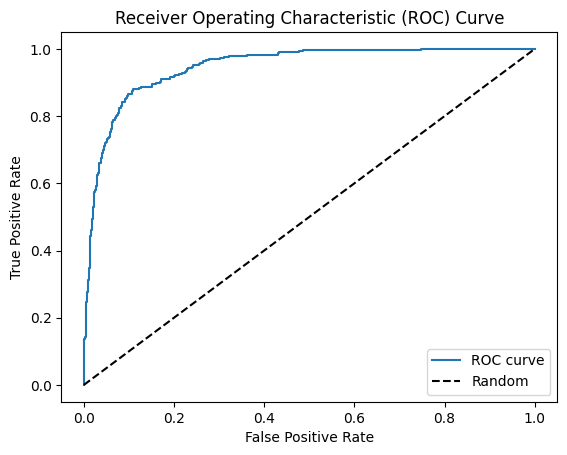

In [ ]:
fpr, tpr, thresholds = roc_curve(actuals_train, predictions_train)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Results Visualization

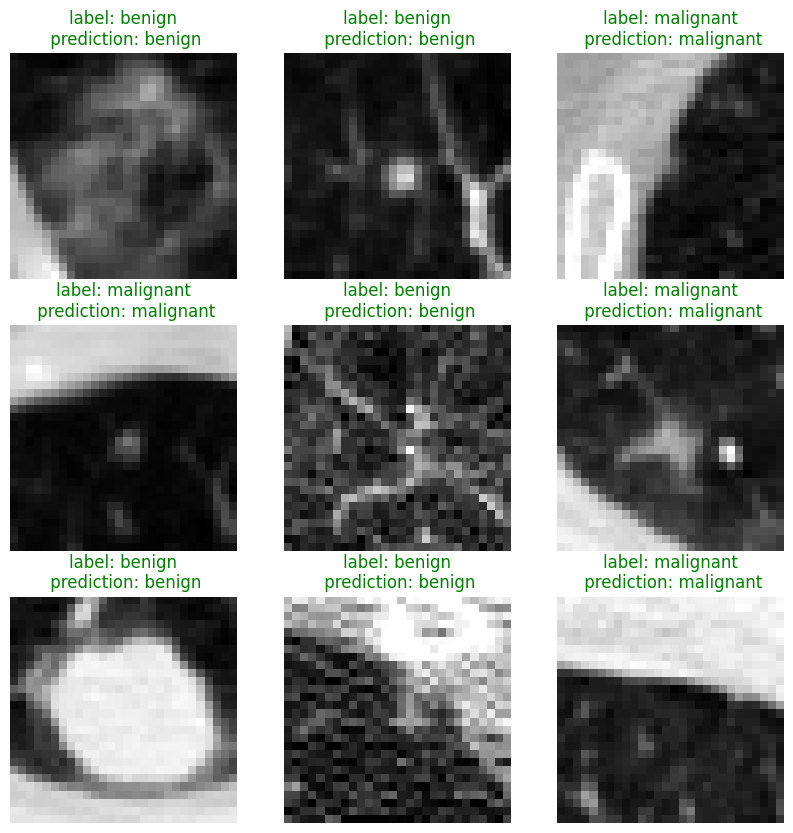

In [ ]:

labels_map = {
    0: "benign",
    1: "malignant",
}


fig = plt.figure(figsize=(10, 10))
for i in range(9):
    index = np.random.randint(0, len(train_dataset))
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_dataset[index][0][0].permute(1, 2, 0)[:,:,12],cmap = "gray")
    plt.axis('off')
    prediction = (0 if predictions_train[index] < .5 else 1)

    plt.title("label: "+str(labels_map[actuals_train[index][0]])+ "\n prediction: "+ str(labels_map[prediction]),color="green" if prediction == actuals_train[index] else "red" )

# Save the model

In [ ]:
PATH = "drive/MyDrive/nodule_3d/CNN_model"
# torch.save(model.state_dict(), PATH)


# Hyperparameter Tuning
[reference](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)

In [ ]:
def train_nodule3d(config):
    net = CNN_3D(in_channels=n_channels, num_classes=n_classes).to(device)
    net.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)


    checkpoint = session.get_checkpoint()


    start_epoch = 0

    trainloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)  # shuffling is enabled in the training
    valloader = DataLoader(validation_dataset, batch_size=config["batch_size"], shuffle=False)

    for epoch in range(start_epoch, 10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            images=inputs.float()


            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1


        # Validation loss
        val_loss = 0.0
        val_steps = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device,dtype=torch.float), labels.to(device,dtype=torch.float)

                outputs = net(inputs)

                loss = criterion(outputs.float(), labels.float())
                val_loss += loss.cpu().numpy()
                val_steps += 1

        checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }


        session.report(
            {"loss": val_loss / val_steps,},
            checkpoint=checkpoint,
        )
    print("Finished Training")




In [ ]:
config = {

    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([16, 32, 64, 128])
}

result = tune.run(train_nodule3d,
    config=config,
    num_samples=5,
    resources_per_trial={"cpu": 2, "gpu": 1}
    )



2023-11-13 18:21:11,793	INFO tune.py:595 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-11-13 18:21:11,914	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+-----------------------------------------------------------------------+
| Configuration for experiment     train_nodule3d_2023-11-13_18-21-11   |
+-----------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                |
| Scheduler                        FIFOScheduler                        |
| Number of trials                 5                                    |
+-----------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_nodule3d_2023-11-13_18-21-11

Trial status: 5 PENDING
Current time: 2023-11-13 18:21:14. Total running time: 2s
Logical resource usage: 0/2 CPUs, 0/1 GPUs
+--------------------------------------------------------------------+
| Trial name                   status              lr     batch_size |
+--------------------------------------------------------------------+
| train_nodule3d_6c7cc_00000   PENDING    0.012487           

2023-11-13 18:21:14,247	WARNING worker.py:2074 -- Warning: The actor ImplicitFunc is very large (55 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(pid=18102) 2023-11-13 18:21:24.039460: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=18102) 2023-11-13 18:21:24.039936: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=18102) 2023-11-13 18:21:24.039995: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=18102) 2023-11-13 18:21:25.579062: W tensorflow/compiler


Trial train_nodule3d_6c7cc_00000 started with configuration:
+-----------------------------------------------------+
| Trial train_nodule3d_6c7cc_00000 config             |
+-----------------------------------------------------+
| batch_size                                       32 |
| lr                                          0.01249 |
+-----------------------------------------------------+

Trial train_nodule3d_6c7cc_00000 finished iteration 1 at 2023-11-13 18:21:29. Total running time: 17s
+-----------------------------------------------------+
| Trial train_nodule3d_6c7cc_00000 result             |
+-----------------------------------------------------+
| checkpoint_dir_name                                 |
| time_this_iter_s                            2.69947 |
| time_total_s                                2.69947 |
| training_iteration                                1 |
| loss                                        0.35293 |
+--------------------------------------------------

(pid=18319) 2023-11-13 18:22:00.438033: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=18319) 2023-11-13 18:22:00.438089: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=18319) 2023-11-13 18:22:00.438115: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=18319) 2023-11-13 18:22:01.748873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_nodule3d_6c7cc_00001 started with configuration:
+-----------------------------------------------------+
| Trial train_nodule3d_6c7cc_00001 config             |
+-----------------------------------------------------+
| batch_size                                       32 |
| lr                                          0.00033 |
+-----------------------------------------------------+

Trial train_nodule3d_6c7cc_00001 finished iteration 1 at 2023-11-13 18:22:05. Total running time: 53s
+-----------------------------------------------------+
| Trial train_nodule3d_6c7cc_00001 result             |
+-----------------------------------------------------+
| checkpoint_dir_name                                 |
| time_this_iter_s                            2.74564 |
| time_total_s                                2.74564 |
| training_iteration                                1 |
| loss                                        0.56904 |
+--------------------------------------------------

(pid=18537) 2023-11-13 18:22:37.065332: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=18537) 2023-11-13 18:22:37.065386: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=18537) 2023-11-13 18:22:37.065411: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=18537) 2023-11-13 18:22:38.328853: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_nodule3d_6c7cc_00002 started with configuration:
+-----------------------------------------------------+
| Trial train_nodule3d_6c7cc_00002 config             |
+-----------------------------------------------------+
| batch_size                                       16 |
| lr                                          0.03597 |
+-----------------------------------------------------+

Trial train_nodule3d_6c7cc_00002 finished iteration 1 at 2023-11-13 18:22:42. Total running time: 1min 30s
+-----------------------------------------------------+
| Trial train_nodule3d_6c7cc_00002 result             |
+-----------------------------------------------------+
| checkpoint_dir_name                                 |
| time_this_iter_s                            2.83001 |
| time_total_s                                2.83001 |
| training_iteration                                1 |
| loss                                        0.55447 |
+---------------------------------------------

(pid=18757) 2023-11-13 18:23:14.146269: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=18757) 2023-11-13 18:23:14.146320: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=18757) 2023-11-13 18:23:14.146350: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Trial status: 3 TERMINATED | 2 PENDING
Current time: 2023-11-13 18:23:14. Total running time: 2min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs
+-------------------------------------------------------------------------------------------------------------+
| Trial name                   status                lr     batch_size     iter     total time (s)       loss |
+-------------------------------------------------------------------------------------------------------------+
| train_nodule3d_6c7cc_00000   TERMINATED   0.012487                32       10            23.0198   0.348995 |
| train_nodule3d_6c7cc_00001   TERMINATED   0.000333336             32       10            23.9674   0.327224 |
| train_nodule3d_6c7cc_00002   TERMINATED   0.0359727               16       10            24.7037   0.433742 |
| train_nodule3d_6c7cc_00003   PENDING      0.06343                128                                        |
| train_nodule3d_6c7cc_00004   PENDING      0.00550379            

(pid=18757) 2023-11-13 18:23:15.396597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_nodule3d_6c7cc_00003 started with configuration:
+-----------------------------------------------------+
| Trial train_nodule3d_6c7cc_00003 config             |
+-----------------------------------------------------+
| batch_size                                      128 |
| lr                                          0.06343 |
+-----------------------------------------------------+

Trial train_nodule3d_6c7cc_00003 finished iteration 1 at 2023-11-13 18:23:19. Total running time: 2min 7s
+-----------------------------------------------------+
| Trial train_nodule3d_6c7cc_00003 result             |
+-----------------------------------------------------+
| checkpoint_dir_name                                 |
| time_this_iter_s                            2.73226 |
| time_total_s                                2.73226 |
| training_iteration                                1 |
| loss                                        0.42196 |
+----------------------------------------------

(pid=18974) 2023-11-13 18:23:50.419893: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=18974) 2023-11-13 18:23:50.419953: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=18974) 2023-11-13 18:23:50.419983: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=18974) 2023-11-13 18:23:51.701845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_nodule3d_6c7cc_00004 started with configuration:
+----------------------------------------------------+
| Trial train_nodule3d_6c7cc_00004 config            |
+----------------------------------------------------+
| batch_size                                      16 |
| lr                                          0.0055 |
+----------------------------------------------------+

Trial train_nodule3d_6c7cc_00004 finished iteration 1 at 2023-11-13 18:23:55. Total running time: 2min 43s
+-----------------------------------------------------+
| Trial train_nodule3d_6c7cc_00004 result             |
+-----------------------------------------------------+
| checkpoint_dir_name                                 |
| time_this_iter_s                             2.7559 |
| time_total_s                                 2.7559 |
| training_iteration                                1 |
| loss                                        0.36081 |
+---------------------------------------------------

In [ ]:
best_trial = result.get_best_trial(metric="loss",mode="min")

In [ ]:
print(best_trial.config)

{'lr': 0.000333336393095575, 'batch_size': 32}


# Re-train with the new parameters

In [ ]:
# hyparameters
BATCH_SIZE = 32
EPOCH_NUM = 35
learn_rate = 0.0003

|##################################################|  100.00% Epoch [1/35], Training Loss: 0.67352, Validation Loss: 0.69083
|##################################################|  100.00% Epoch [2/35], Training Loss: 0.60054, Validation Loss: 0.63881
|##################################################|  100.00% Epoch [3/35], Training Loss: 0.5604, Validation Loss: 0.57639
|##################################################|  100.00% Epoch [4/35], Training Loss: 0.51774, Validation Loss: 0.51804
|##################################################|  100.00% Epoch [5/35], Training Loss: 0.47702, Validation Loss: 0.46572
|##################################################|  100.00% Epoch [6/35], Training Loss: 0.44172, Validation Loss: 0.41834
|##################################################|  100.00% Epoch [7/35], Training Loss: 0.42144, Validation Loss: 0.38574
|##################################################|  100.00% Epoch [8/35], Training Loss: 0.40017, Validation Loss: 0.35899
|

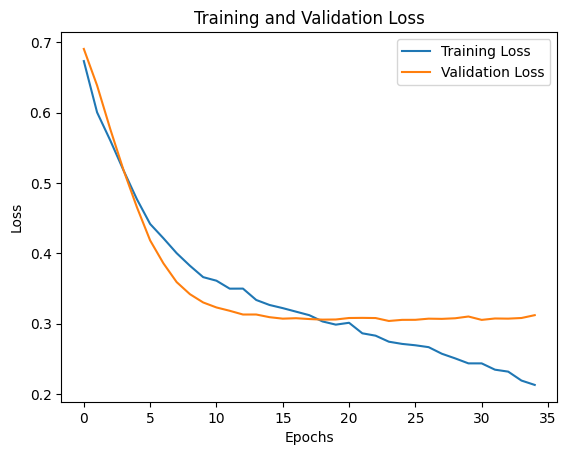

In [ ]:
train_loss, val_loss = train(train_loader, model, optimizer, criterion, EPOCH_NUM, validation_loader)


# learning curves
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
actuals_train, predictions_train, AUC_train, ACC_train = test(train_loader, model,criterion)
actuals_val, predictions_val, AUC_val, ACC_val = test(validation_loader, model,criterion)


print(f' Training --> AUC: {AUC_train:.3f}, ACC: {ACC_train:.3f}\n')
print(f' Validation --> AUC: {AUC_val:.3f}, ACC: {ACC_val:.3f}\n')

 Training --> AUC: 0.973, ACC: 0.930

 Validation --> AUC: 0.893, ACC: 0.861



# (############)